In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
import statistics as stat
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from mlxtend.plotting import plot_decision_regions
from sklearn.utils import shuffle
from mlxtend.plotting import plot_decision_regions


# Question 1)

In [2]:
class SVM_Preceptron():
    def __init__(self):
        self.le = LabelEncoder()

    def readData(self, file_name):
        df = pd.read_csv(file_name)
        return df

    def train_test_split(self,training_df,test_df):
        xtrain = training_df.iloc[:,:-1]
        xtest = test_df.iloc[:, :-1]
        ytrain = training_df["UNS"]
        ytest = test_df["UNS"]
        return xtrain,xtest,ytrain,ytest

    def visualize(self,df):
        sns.countplot(x="UNS",data=df ,hue='UNS') 
        plt.show()
        sns.pairplot(df, hue="UNS")
        plt.show()

    def labelbinarizer(self, ytrain, ytest):
        y_train = self.le.fit_transform(ytrain)
        y_test = self.le.fit_transform(ytest)
        return np.array(y_train), np.array(y_test)

    def select_best_features(self,x,y,num_of_features):
        bestfeatures = SelectKBest(score_func=chi2, k=num_of_features)
        fit = bestfeatures.fit_transform(x, y)
        bestfeatures.get_feature_names_out()
        return fit, bestfeatures.get_feature_names_out()

    def cross_validation(self,clf,x,y):
        scores = cross_val_score(clf, x, y, cv=10)
        return scores.mean()

    def svm(self, xtrain, ytrain, xtest, ytest):
        clf = SVC()
        clf.fit(xtrain, ytrain)
        pred = clf.predict(xtest)
        print(self.model_accuracy(ytest, pred, "SVM Model Accuracy: "))
        
        print("Cross Validation on Training set: {}%".format(
            100*self.cross_validation(clf,xtrain,ytrain)))

        self.plot_confusion(clf, ytest, pred, "SVM confusion matrix: ")
        self.draw_decision_region(
            xtrain, ytrain, clf, "SVM Decision boundries: ")

    def preceptron(self, xtrain, ytrain, xtest, ytest):
        clf = Perceptron()
        clf.fit(xtrain, ytrain)
        pred = clf.predict(xtest)
        print(self.model_accuracy(ytest, pred, "Preceptron Model Accuracy: "))
        print("Cross Validation on Training set: {}%".format(
            100*self.cross_validation(clf, xtrain, ytrain)))
        self.plot_confusion(clf, ytest, pred, "Preceptron confusion matrix: ")
        self.draw_decision_region(
            xtrain, ytrain, clf, "Preceptron Decision boundries: ")


    def model_accuracy(self, y_test, predictions, title):
        return title+"{}%".format(100*accuracy_score(y_test, predictions))

    def plot_confusion(self, clf, ytest, ypredict, title):
        cm = confusion_matrix(ytest, ypredict, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot()
        plt.title(title)
        plt.show()

    def draw_decision_region(self, x, y, clf, title):
        plt.title(title)
        plot_decision_regions(x, y, clf)
        plt.show()
        


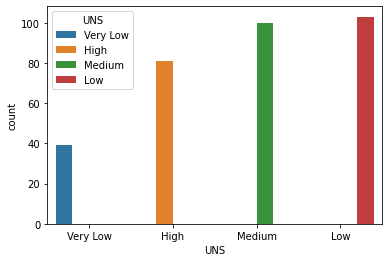

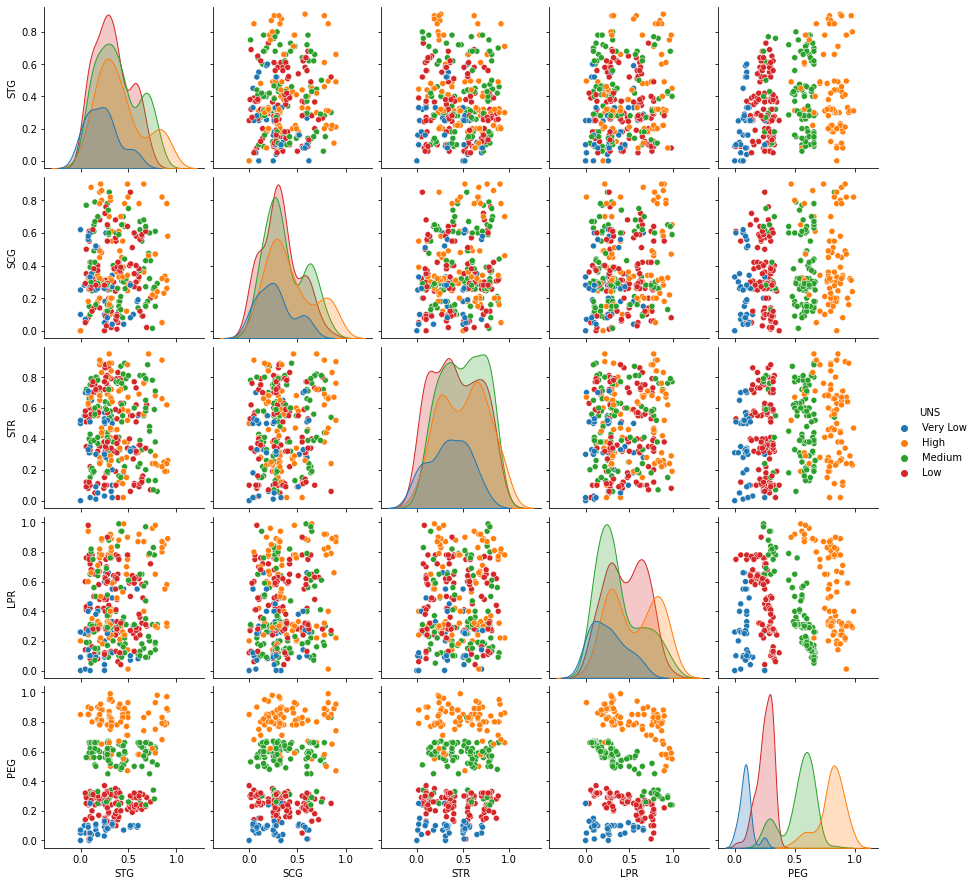

SVM Model Accuracy: 98.75%
Cross Validation on Training set: 95.39772727272727%


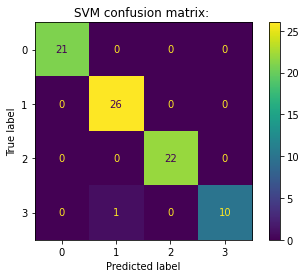

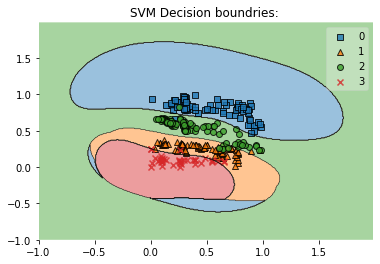

Preceptron Model Accuracy: 60.0%
Cross Validation on Training set: 63.81628787878788%


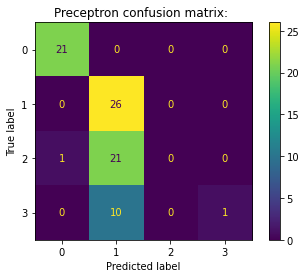

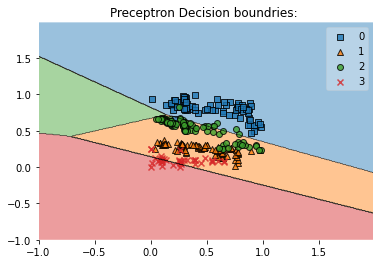

In [3]:
svm_prec = SVM_Preceptron()

training_df = svm_prec.readData("DUMD_train.csv")
test_df = svm_prec.readData("DUMD_test.csv")

svm_prec.visualize(training_df)


xtrain, xtest, ytrain, ytest = svm_prec.train_test_split(training_df,test_df)

ytrain,ytest = svm_prec.labelbinarizer(ytrain,ytest)
xtrain,best_features= svm_prec.select_best_features(xtrain,ytrain,2)
xtest = xtest[list(best_features)].to_numpy()

svm_prec.svm(xtrain,ytrain,xtest,ytest)
svm_prec.preceptron(xtrain, ytrain, xtest, ytest)
#print(xtest,"\n",test_df[["LPR","PEG"]].head)

# Question 2) OvR

In [4]:
class OvR_clf:
    def __init__(self):
        self.preds=[]
        self.mlb = MultiLabelBinarizer()
        self.le = LabelEncoder()
    
    def readData(self, file_name):
        df = pd.read_csv(file_name)
        return df
    
    def labelbinarizer(self,ytrain,ytest):
        y_train = self.mlb.fit_transform(ytrain.reshape(-1,1))
        y_test = self.mlb.fit_transform(ytest.reshape(-1,1))
        return np.array(y_train),np.array(y_test)

    #main function to fit model and prinitng all metrics
    def model_prediction(self,x,y,xtest,ytest):
        for i in range(4):
            clf= SVC(kernel='linear', probability=True)
            clf.fit(x, y[:, i])
            ypred = clf.predict(xtest)
            self.preds.append(clf.predict_proba(xtest)[:, 1].reshape(-1, 1))
            print(self.model_accuracy(ytest[:, i], ypred))
            self.plot_confusion(clf,ytest[:, i],ypred)
            self.draw_decision_region(xtest, ytest[:, i], clf)

    #predictions using propabilities
    def prob_argmax(self,ytest):
        yb_all = np.hstack((self.preds[0], self.preds[1], self.preds[2], self.preds[3]))
        m = np.argmax(yb_all, axis=1)
        ytest = self.le.fit_transform(ytest)
        print(self.model_accuracy(list(ytest), list(m)))

    def model_accuracy(self, y_test, predictions, title="OvR Model Accuracy: "):
        return title+"{}%".format(100*accuracy_score(y_test, predictions))

    def plot_confusion(self, clf, ytest, ypredict, title="OvR Model confusion matrix"):
        cm = confusion_matrix(ytest, ypredict, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot()
        plt.title(title)
        plt.show()
        
    def draw_decision_region(self, x, y, clf, title="OvR Model Decision boundries"):
        plt.title(title)
        plot_decision_regions(x, y, clf)
        plt.show()
    

OvR Model Accuracy: 100.0%


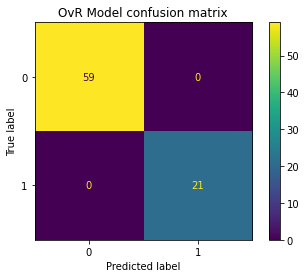

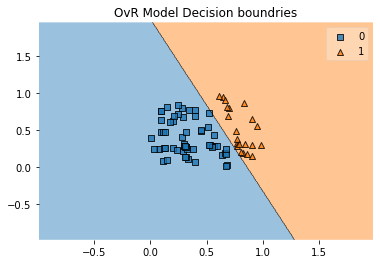

OvR Model Accuracy: 80.0%


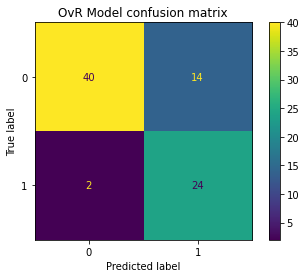

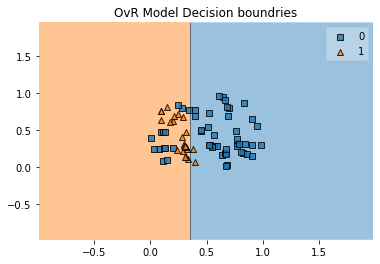

OvR Model Accuracy: 72.5%


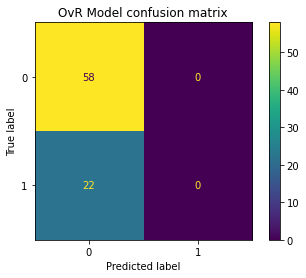

d:\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


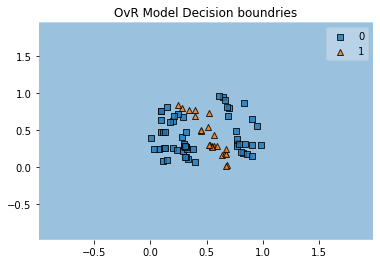

OvR Model Accuracy: 93.75%


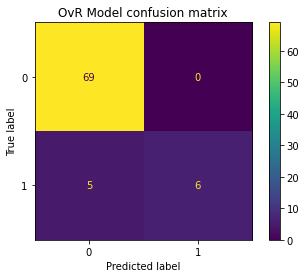

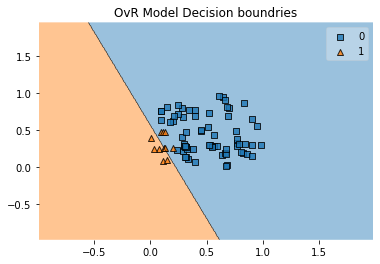

In [5]:
ovr = OvR_clf()
training_df = ovr.readData("DUMD_train.csv")
test_df = ovr.readData("DUMD_test.csv")


xtrain = training_df[["PEG", "LPR"]].to_numpy()
ytrain = training_df["UNS"].to_numpy()


xtest = test_df[["PEG", "LPR"]].to_numpy()
ytest = test_df["UNS"].to_numpy()

ytrain,ytest = ovr.labelbinarizer(ytrain,ytest)
ovr.model_prediction(xtrain,ytrain,xtest,ytest)

In [6]:
y_test = test_df["UNS"].to_numpy()
ovr.prob_argmax(y_test)


OvR Model Accuracy: 86.25%


# Question 3) OvO

In [7]:
class OvO_clf:    
    def __init__(self):
        self.clf_prop = []
        pass
    
    def readData(self,file_name):
        df = pd.read_csv(file_name)
        return df

    def binarize(self,ytrain,ytest):
        ytrain.replace("Very Low", 0, inplace=True)
        ytrain.replace("Low", 1, inplace=True)
        ytrain.replace("Medium", 2, inplace=True)
        ytrain.replace("High", 3, inplace=True)

        ytest.replace("Very Low", 0, inplace=True)
        ytest.replace("Low", 1, inplace=True)
        ytest.replace("Medium", 2, inplace=True)
        ytest.replace("High", 3, inplace=True)

        return ytrain,ytest

    # Get data of difint pair (for Ex. get x and y that contain very low and low)
    def preparing_OvO(self,x, y, pair):
        valid = (y == pair[0]) | (y == pair[1])
        return x[valid], y[valid]
    
    # main function to loop on models and print acc, confusion matrix and decision boundries 
    def get_pairs_OvO(self,x,y,xtest,ytest):
        li = [(0, 1), (0, 2), (0, 3),
            (1, 2), (1, 3), (2, 3)]
        li_of_clf = []
        for el in li:
            x1, y1 = self.preparing_OvO(x, y, el)
            clf = SVC(kernel='linear', probability=True)
            clf.fit(x1, y1)
            ypred =clf.predict(xtest)
            prop = clf.predict_proba(xtest)
            self.clf_prop.append(prop)
            print(self.model_accuracy(np.array(ytest),np.array(ypred)))
            self.plot_confusion(clf, ytest, ypred)
            self.draw_decision_region(np.array(x1), np.array(y1), clf)
            li_of_clf.append(clf)
        return li_of_clf
            
    #predictions and accuracy using majority voting
    def model_prediction_majority_voting(self, li_of_model,x):
        li_of_pred = []
        for model in li_of_model:
            li_of_pred.append(model.predict(x)[0])
        return stat.mode(li_of_pred)
    
    def model_accuracy(self,y_test,predictions):
        return "OvO Model Accuracy: {}%".format(100*accuracy_score(y_test,predictions))
    
    def plot_confusion(self, clf, ytest, ypredict):
        cm = confusion_matrix(ytest, ypredict, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot()
        plt.title("OvR Model confusion matrix")
        plt.show()

    def draw_decision_region(self,x,y,clf):
        plt.title("OvO Model Decision boundries")
        plot_decision_regions(x,y,clf)
        #plt.legend(labels=["m","n"])
        plt.show()

    #predictions and accuracy using propabilities
    def model_prediction_prop(self,ytest):
        prop0 = np.array(self.clf_prop[0][:, 0] + self.clf_prop[1][:, 0]+self.clf_prop[2][:, 0])/3.0

        prop1 = np.array(
            self.clf_prop[0][:, 1] + self.clf_prop[3][:, 0] + self.clf_prop[4][:, 0])/3.0

        prop2 = np.array(
            self.clf_prop[1][:, 1] + self.clf_prop[3][:, 1] + self.clf_prop[5][:, 0])/3.0
        prop3 = np.array(
            self.clf_prop[2][:, 1] + self.clf_prop[4][:, 1] + self.clf_prop[5][:, 1])/3.0

        prop0 = prop0.reshape(-1, 1)
        prop1 = prop1.reshape(-1, 1)
        prop2 = prop2.reshape(-1, 1)
        prop3 = prop3.reshape(-1, 1)

        yb_all = np.hstack((prop0, prop1, prop2, prop3))

        m = np.argmax(yb_all, axis=1)
        print(self.model_accuracy(list(ytest), list(m)))


OvO Model Accuracy: 40.0%


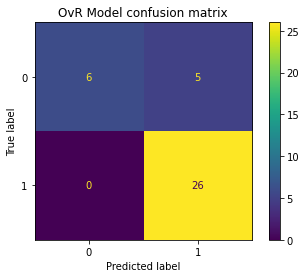

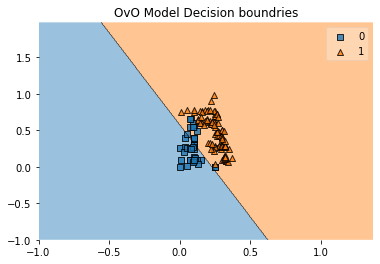

OvO Model Accuracy: 41.25%


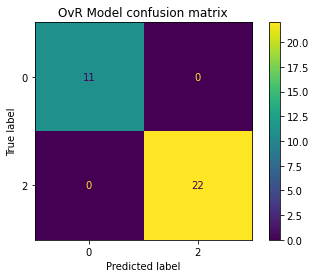

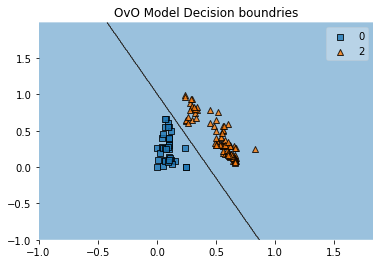

OvO Model Accuracy: 40.0%


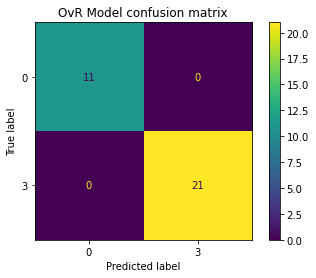

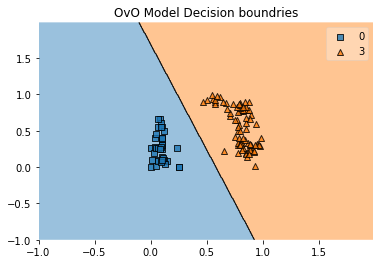

OvO Model Accuracy: 57.49999999999999%


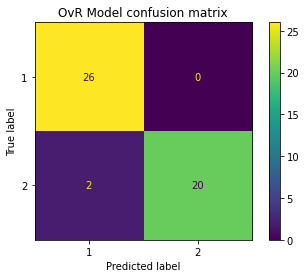

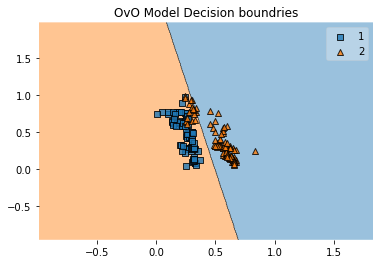

OvO Model Accuracy: 58.75%


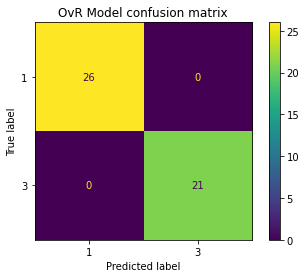

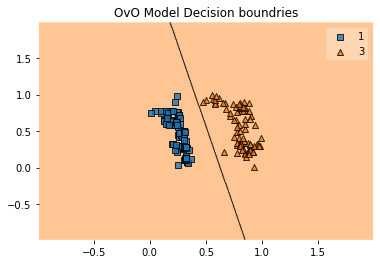

OvO Model Accuracy: 53.75%


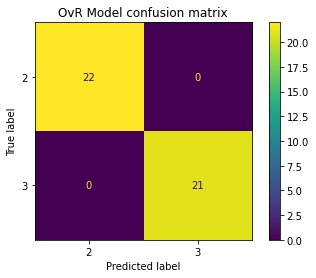

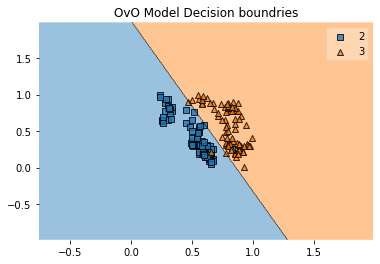

In [8]:
ovo = OvO_clf()
training_df = ovo.readData("DUMD_train.csv")
test_df = ovo.readData("DUMD_test.csv")


xtrain = training_df[["PEG","LPR"]].to_numpy()
ytrain = training_df["UNS"]


xtest = test_df[["PEG", "LPR"]].to_numpy()
ytest = test_df["UNS"]

ytrain,ytest = ovo.binarize(ytrain,ytest)

clf_list = ovo.get_pairs_OvO(xtrain,ytrain,xtest,ytest)
#ovo.draw_decision_region(xtest,le.fit_transform(ytest),clf_list)




In [9]:
y_predicted = []
for x in xtest:
    y_predicted.append(ovo.model_prediction_majority_voting(
        clf_list, x.reshape(1, -1)))
#using Majority Voting
print(ovo.model_accuracy(ytest,y_predicted))

OvO Model Accuracy: 91.25%


In [10]:
#using propabilities
ovo.model_prediction_prop(ytest)

OvO Model Accuracy: 97.5%
